In [1]:
from keras.models import Model, Sequential
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, GRU, Embedding, Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import requests

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Autoencoder

In [63]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# data normalization
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.3, random_state = 666)
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test = to_categorical(y_test, 10)

print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(42000, 28, 28, 1)
(18000, 28, 28, 1)
(42000, 10)
(18000, 10)


In [34]:
# encoding
input_img = Input(shape = (28, 28, 1))

x1 = Conv2D(16, (3, 3), activation = "relu", padding = "same")(input_img) #28*28*32
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size = (2, 2))(x1) # 14*14*32
x2 = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x1) # 14*14*64
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size = (2, 2))(x2) # 7*7*64
x3 = Conv2D(4, (3, 3), activation = "relu", padding = "same")(x2) # 7*7*128
x3 = BatchNormalization()(x3)
x4 = Conv2D(2, (3, 3), activation = "relu", padding = "same")(x3) # 7*7*256
encoded = BatchNormalization()(x4)

In [35]:
# decoding
x5 = Conv2D(4, (3, 3), activation = "relu", padding = "same")(encoded) #7*7*128
x5 = BatchNormalization()(x5)
x6 = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x5) #7*7*64
x6 = BatchNormalization()(x6)
x6 = UpSampling2D(size = (2, 2))(x6) #14*14*64
x7 = Conv2D(16, (3, 3), activation = "relu", padding = "same")(x6)
x7 = BatchNormalization()(x7)
x7 = UpSampling2D(size = (2, 2))(x7) #28*28*32
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x7)

In [36]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [64]:
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 81s 2ms/step - loss: 0.0256 - val_loss: 0.0255
Epoch 2/5
42000/42000 [==============================] - 81s 2ms/step - loss: 0.0211 - val_loss: 0.0252
Epoch 3/5
42000/42000 [==============================] - 79s 2ms/step - loss: 0.0190 - val_loss: 0.0208
Epoch 4/5
42000/42000 [==============================] - 76s 2ms/step - loss: 0.0175 - val_loss: 0.0170
Epoch 5/5
42000/42000 [==============================] - 76s 2ms/step - loss: 0.0165 - val_loss: 0.0172


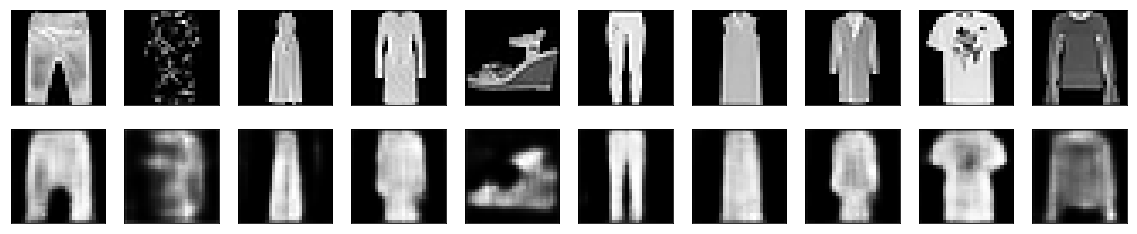

In [65]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Iamge Classification

## Deep CNN

In [66]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = "relu", padding = "same", input_shape = (28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = "relu", padding = "same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = "relu", padding = "same"))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(10, activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adadelta", metrics = ["accuracy"])

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               802944    
__________

In [42]:
train_model = model.fit(x_train, y_train, 
                        epochs = 10, batch_size = 128, 
                        verbose = 1, validation_data = (x_test, y_test))

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 54s 1ms/step - loss: 0.6102 - acc: 0.7758 - val_loss: 0.5329 - val_acc: 0.7747
Epoch 2/10
42000/42000 [==============================] - 52s 1ms/step - loss: 0.3440 - acc: 0.8759 - val_loss: 0.4427 - val_acc: 0.8474
Epoch 3/10
42000/42000 [==============================] - 52s 1ms/step - loss: 0.2897 - acc: 0.8952 - val_loss: 0.2984 - val_acc: 0.8908
Epoch 4/10
42000/42000 [==============================] - 51s 1ms/step - loss: 0.2529 - acc: 0.9067 - val_loss: 0.2730 - val_acc: 0.9016
Epoch 5/10
42000/42000 [==============================] - 51s 1ms/step - loss: 0.2268 - acc: 0.9160 - val_loss: 0.3109 - val_acc: 0.8904
Epoch 6/10
42000/42000 [==============================] - 51s 1ms/step - loss: 0.2033 - acc: 0.9245 - val_loss: 0.3377 - val_acc: 0.8790
Epoch 7/10
42000/42000 [==============================] - 51s 1ms/step - loss: 0.1852 - acc: 0.9313 - val_loss: 0.2857 - val_acc

In [43]:
score = model.evaluate(x_test, y_test, verbose = 0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3006312627315521
Test accuracy: 0.8932


## Transfer Lenarning

In [68]:
def img_preprocess_vgg16(x):
    x = x.repeat(3, axis = -1)
    x = np.asarray([img_to_array(array_to_img(im, scale = False).resize((32,32))) for im in x])
    return x
x_train = img_preprocess_vgg16(x_train)
x_test = img_preprocess_vgg16(x_test)

In [69]:
conv_base = VGG16(weights = "imagenet", include_top = False, input_shape = (32, 32, 3))
model_tl = Sequential()
model_tl.add(conv_base)
model_tl.add(Flatten())
model_tl.add(Dense(512, activation = "relu"))
model_tl.add(Dense(10, activation = "softmax"))
conv_base.trainable = False
model_tl.trainable_weights

[<tf.Variable 'dense_11/kernel:0' shape=(512, 512) dtype=float32_ref>,
 <tf.Variable 'dense_11/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'dense_12/kernel:0' shape=(512, 10) dtype=float32_ref>,
 <tf.Variable 'dense_12/bias:0' shape=(10,) dtype=float32_ref>]

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               802944    
__________

In [71]:
model_tl.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["acc"])

In [72]:
model_tl.fit(x_train, y_train, batch_size = 128, epochs = 1, validation_data = (x_test, y_test))

Train on 42000 samples, validate on 18000 samples
Epoch 1/1
42000/42000 [==============================] - 463s 11ms/step - loss: 1.9322 - acc: 0.2997 - val_loss: 1.8022 - val_acc: 0.3497


# Text Classification
## RNN

In [51]:
url_b = requests.get("https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt").text.split("\n")
url_m = requests.get("https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt").text.split("\n")
url_b = [x for x in url_b if x[0] != "#"]
X_train = np.asarray(url_b + url_m)
Y_train = np.concatenate((np.ones(len(url_b)), np.zeros(len(url_m))))
print(len(url_b))
print(len(url_m))
tokenizer = Tokenizer(char_level = True)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train, mode = "count")
print(X_train.shape)
maxlen = X_train.shape[1]

66015
1297
(67312, 42)


In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 1234)

In [53]:
model_text_rnn = Sequential()
model_text_rnn.add(Embedding(input_dim = 100, output_dim = 32, input_length = maxlen))
model_text_rnn.add(GRU(32))
model_text_rnn.add(Dense(1, activation = "sigmoid"))
model_text_rnn.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["acc"])

In [56]:
model_text_rnn.fit(X_train, Y_train, epochs = 1, batch_size = 128, validation_data = (X_test, Y_test), verbose = 1)

Train on 23559 samples, validate on 10097 samples
Epoch 1/1
23559/23559 [==============================] - 8s 341us/step - loss: 0.1308 - acc: 0.9769 - val_loss: 0.1011 - val_acc: 0.9794


In [57]:
score_rnn = model_text_rnn.evaluate(X_test, Y_test, verbose = 0)
print("Test loss:", score_rnn[0])
print("Test accuracy:", score_rnn[1])

Test loss: 0.10111122366641966
Test accuracy: 0.9793998217292265


## CNN

In [58]:
model_text_cnn = Sequential()
model_text_cnn.add(Embedding(input_dim = 100, output_dim = 32, input_length = maxlen))
model_text_cnn.add(Conv1D(256, 3, activation = "relu"))
model_text_cnn.add(MaxPooling1D(3))
model_text_cnn.add(Flatten())
model_text_cnn.add(Dense(256, activation = "relu"))
model_text_cnn.add(Dense(1, activation = "sigmoid"))
model_text_cnn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["acc"])

In [59]:
model_text_cnn.fit(X_train, Y_train, batch_size = 128, epochs = 1, validation_data = (X_test, Y_test))

Train on 23559 samples, validate on 10097 samples
Epoch 1/1
23559/23559 [==============================] - 8s 321us/step - loss: 0.0795 - acc: 0.9783 - val_loss: 0.0555 - val_acc: 0.9794


In [60]:
score_cnn = model_text_cnn.evaluate(X_test, Y_test, verbose = 0)
print("Test loss:", score_cnn[0])
print("Test accuracy:", score_cnn[1])

Test loss: 0.05548836648422881
Test accuracy: 0.9793998217292265


## Compare RNN & CNN

In [61]:
Y_rnn = model_text_rnn.predict(X_test).ravel()
Y_cnn = model_text_cnn.predict(X_test).ravel()
fpr_r, tpr_r, thresholds_r = roc_curve(Y_test, Y_rnn)
auc_r = auc(fpr_r, tpr_r)
fpr_c, tpr_c, thresholds_c = roc_curve(Y_test, Y_cnn)
auc_c = auc(fpr_c, tpr_c)

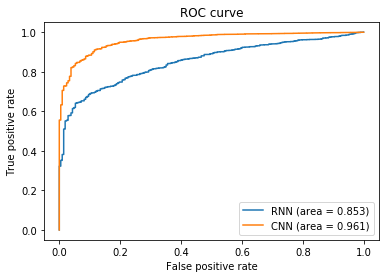

In [62]:
plt.figure(1)
plt.plot(fpr_r, tpr_r, label='RNN (area = {:.3f})'.format(auc_r))
plt.plot(fpr_c, tpr_c, label='CNN (area = {:.3f})'.format(auc_c))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()